# Poor Attendance Visualisation

### Importing necessary libraries

In [9]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

# from CW_Preprocessing import *
import ipynb
from ipynb.fs.defs.CW_Preprocessing import *
from ipywidgets import widgets
from IPython import get_ipython


### PoorAtt Class

In [10]:
class PoorAtt:
    """
    Class for generating tables and scatter plots to visualize the attendance
    records, and for identifying students with poor attendance records.
    """
    def __init__(self, modules_list):
        """
        Parameters:
        modules_list (list): A list of module codes.

        Attributes:
        modules_list (list): A list of module codes.
        selected_modules_df (pandas.DataFrame): Dataframe containing attendance
        records of all the selected modules.
        students_weekly_avg_att (pandas.DataFrame): Dataframe containing weekly
        average attendance percentage of all students.
        modules_weekly_avg_att (pandas.DataFrame): Dataframe containing weekly
        average attendance percentage of all modules.
        dept_avg (float): Department average attendance percentage.
        below_avg_att (pandas.DataFrame): Dataframe containing records of
        students having attendance lower than department average.
        """
        self.modules_list = modules_list
        self.selected_modules_df = self.merge_modules()
        self.students_weekly_avg_att = self.get_student_weekly_avg_att()
        self.modules_weekly_avg_att = self.get_module_weekly_avg_att()
        self.dept_avg = round(self.selected_modules_df.att.mean()*100, 2)
        self.below_avg_att = self.get_below_avg_att_df()

    def merge_modules(self):
        """
        function to merge all modules attendance records into a single dataframe

        Returns:
        pandas.DataFrame: A dataframe containing attendance records for all the
        selected modules.
        """
        combined_df = pd.DataFrame()
        for module in self.modules_list:
            att_df = ModuleRecord(module).wide_to_long()
            combined_df = pd.concat([combined_df, att_df])
        return combined_df

    def get_student_weekly_avg_att(self):
        """
        function to calculate the average attendance for each combination of
        student id and week.

        returns:
        students_weekly_avg_att(Dataframe): Pivot table  with the values being
        the average attendance ,the index being the student id (sid), and the
        columns being the week and average attendance.
        """
        students_weekly_avg_att = pd.pivot_table(self.selected_modules_df,
                                                      values="att",
                                                      index="sid",
                                                      columns="week",
                                                      aggfunc=np.mean
                                                      )
        students_avg_att = self.selected_modules_df.groupby("sid")["att"].mean()
        students_weekly_avg_att['Average %'] = students_avg_att
        students_weekly_avg_att = students_weekly_avg_att.sort_values(by="Average %")
        students_weekly_avg_att = (students_weekly_avg_att * 100).round(1)
        return students_weekly_avg_att

    def get_below_avg_att_df(self):
        """
        function to get students with attendance lower than the average
        attendance of selected modules.

        returns:
        DataFrame:
        """
        return self.students_weekly_avg_att[
            self.students_weekly_avg_att['Average %'] < self.dept_avg]

    def get_module_weekly_avg_att(self):
        """
        function to calculate the average attendance for each combination of
        student id and week.

        parameters:
        selected_module_df(DataFrame): Instance Variable

        returns:
        DataFrame: Pivot table  with the values being the average attendance ,
        the index being the week, and the columns being the selected modules.

        """
        modules_weekly_avg_att = pd.pivot_table(self.selected_modules_df,
                                                     values="att",
                                                     index="week",
                                                     columns="module",
                                                     aggfunc=np.mean
                                                     )
        modules_weekly_avg_att['Average %'] = modules_weekly_avg_att.mean(axis=1)
        modules_weekly_avg_att = modules_weekly_avg_att.sort_values(by="Average %")
        modules_weekly_avg_att = (modules_weekly_avg_att * 100).round(1)
        return  modules_weekly_avg_att

    def get_n_students_table(self, n=None):
        """
        Creates and saves a table of students with poor attendance records using
        matplotlib library.

        parameters:
        n (int, optional): if 'n' is specified,this returns top n students with
        poor attendance records.
        student_weekly_avg_att(Dataframe): Instance variable containing weekly
        attendance records of all students.

        returns:
        None: The function saves the table as an image with the filename 'PA.png'
        in the local directory.

        """
        if n:
            df = self.get_below_avg_att_df().head(n)
        else:
            df = self.get_below_avg_att_df()

        cell_colors = []
        for row in range(df.shape[0]):
            row_colors = []
            for col in range(df.shape[1]-1):
                if df.iloc[row, col] > self.dept_avg:
                    row_colors.append("#3CBA54")
                else:
                    row_colors.append("#FFFFFF")
            row_colors.append("#FFFFFF")
            cell_colors.append(row_colors)

        fig, ax = plt.subplots()
        figure = ax.get_figure()
        figure.set_size_inches(6, df.shape[0]*0.18)
        ax.axis('off')
        ax.axis('tight')
        ax.table(cellText=df.values,
                 cellColours=cell_colors,
                 rowLabels=df.index,
                 colLabels=df.columns,
                 loc='center')
        plt.savefig('PA.png')

    def get_scatter_plot(self, sid_list=None):
        """
        Creates a line plot of weekly average attendance percentage for all
        modules and for specific students.

        Parameters:

        sid_list (list of int, optional): If specified, the function will plot
        the attendance record of students specified in this list.

        modules_weekly_avg_att (pandas.Dataframe): Instance variable.

        students_weekly_avg_att (pandas.Dataframe): Instance variable.

        Returns:

        matplotlib.figure.Figure: a figure object containing the line plot

        """
        module_att = self.modules_weekly_avg_att.drop(columns=["Average %"])

        fig, ax = plt.subplots()
        plt.ylim(-5, 110)
        module_att.plot(kind="line", ax=ax)

        student_df = self.students_weekly_avg_att.drop(columns=["Average %"]).T
        if sid_list:
            student_df = student_df[sid_list]
            student_df.plot(kind="line", ax=ax, alpha=0.5,
                            linestyle='dashed',
                            marker='o', markersize=4
                            )
        ax.set_ylabel("Attendance %")
        return fig, ax

    def update_scatter_plot(self, sid_list):
        student_df = self.students_weekly_avg_att.drop(columns=["Average %"]).T
        student_df = student_df[sid_list]
        return student_df







### Testing

In [11]:
def main_py():
    """
    This function will be executed if the file is run as a standalone
    .py script.
    """
    poor_att = PoorAtt(get_modules_list())
    poor_att.get_n_students_table()
    poor_att.get_scatter_plot(sid_list=[44])


def main_ipynb(sid_list):
    """
    This function will be executed if the file is run as a standalone
    .ipynb script.
    """
    legend = ax.legend()
    legend_list_str = [t.get_text() for t in legend.get_texts()]
    legend_list = list(set(legend_list_str) - set(modules_list))
    legend_list = [int(x) for x in legend_list]
    print("legend_list", legend_list)
    print(sid_list)
    to_be_added = list(set(sid_list) - set(legend_list))
    print("to_be_added", to_be_added)
    to_be_removed = [x for x in list(set(legend_list) - set(sid_list))]
    print("to_be_removed", to_be_removed)

    legend_handles = legend.legendHandles
    for label, handle in zip(legend_list_str, legend_handles):
        if label in to_be_removed:
            handle.set_visible(False)

    student_df = poor_att.update_scatter_plot(sid_list)
    student_df = student_df[to_be_added]
    print(student_df)
    student_df.plot(kind="line", ax=ax, alpha=0.5,
                    linestyle='dashed',
                    marker='o', markersize=4
                    )
    fig.canvas.draw()



['22COA111', '22COA122']


<IPython.core.display.Javascript object>


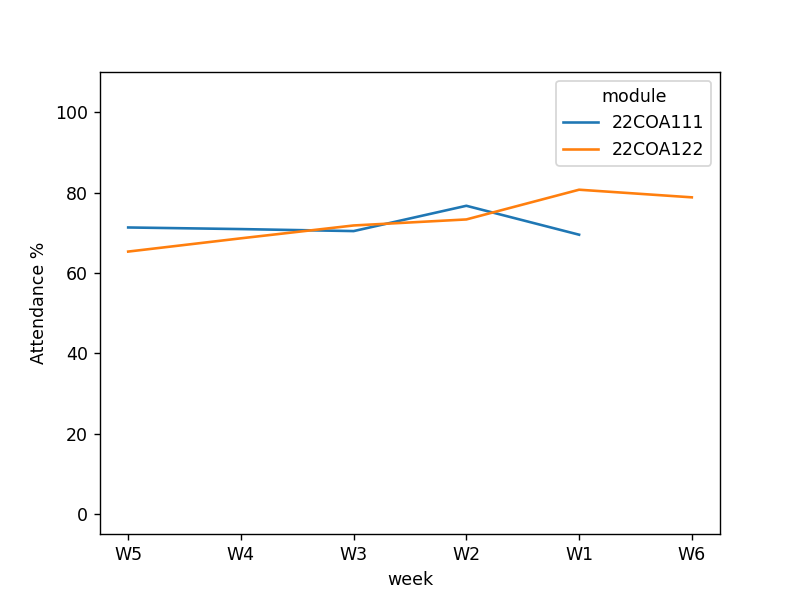

Text(value='', description='Student ID:')

Button(description='Add', style=ButtonStyle())

Button(description='Remove', style=ButtonStyle())

<IPython.core.display.Javascript object>


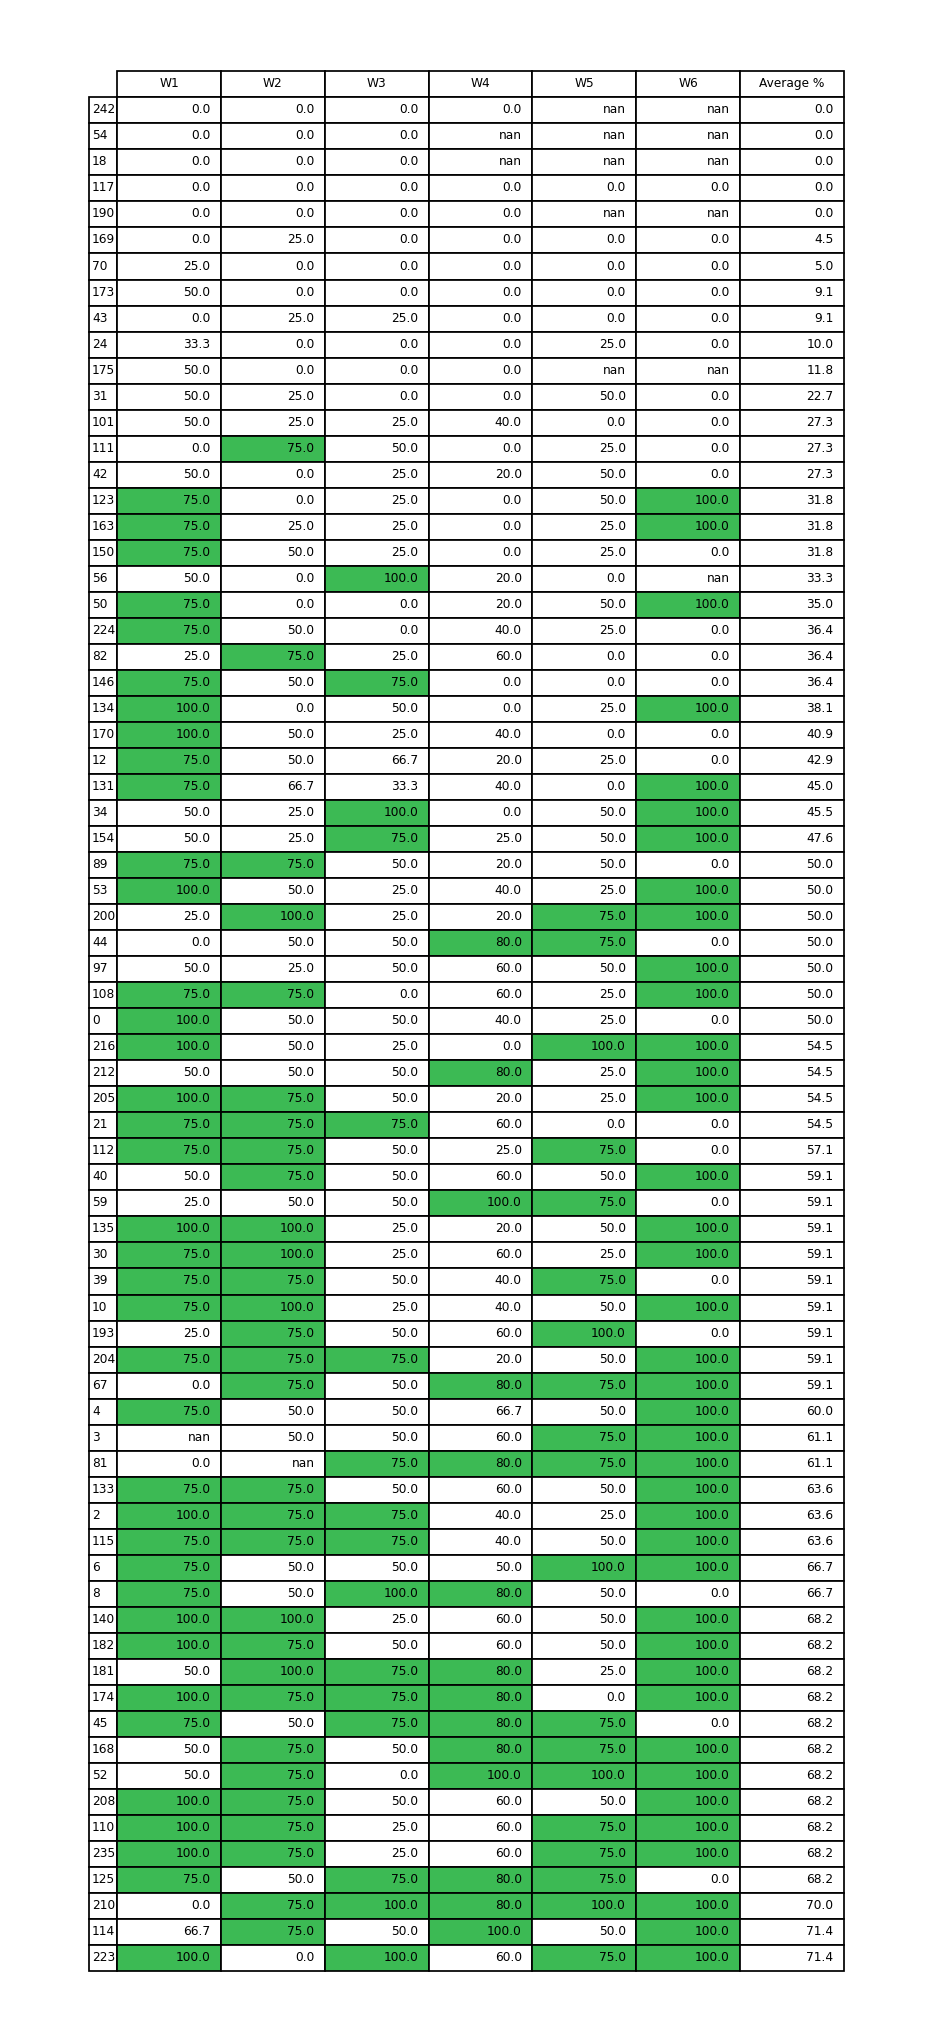

In [12]:
if __name__ == "__main__":
    shell = get_ipython()
    if type(shell).__name__ == 'ZMQInteractiveShell':
        matplotlib.use("nbagg")
        modules_list = get_modules_list()
        print(modules_list)
        poor_att = PoorAtt(modules_list)
        fig, ax = poor_att.get_scatter_plot()

        sid_entry = widgets.Text(description='Student ID:')
        display(sid_entry)

        add_button = widgets.Button(description='Add')
        rem_button = widgets.Button(description='Remove')
        display(add_button, rem_button)

        table = poor_att.get_n_students_table()
        plt.show()

        sid_list = []


        def add_button_clicked(b):
            sid = int(sid_entry.value)
            if sid not in sid_list:
                sid_list.append(sid)
            else:
                print("This SID already added")
            main_ipynb(sid_list)


        add_button.on_click(add_button_clicked)


        def rem_button_clicked(b):
            sid = int(sid_entry.value)
            if sid in sid_list:
                sid_list.remove(sid)
            else:
                print("This SID is not plotted")
            main_ipynb(sid_list)


        rem_button.on_click(rem_button_clicked)

    else:
        main_py()